# **Import Libraries**

## **Install Libraries for the session**

In [ ]:
# --- Install Required Libraries ---
# Install the necessary libraries for dataset handling and hyperparameter optimization
!pip install datasets
!pip install optuna
!pip install nltk

## **Import Libraries**

In [ ]:
## --- Import Libraries ---
# Import all required libraries for data processing, modeling, and evaluation
from google.colab import drive  # For accessing Google Drive
import re
import os
import shutil
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from peft import (
    LoraConfig,
    TaskType,
    get_peft_model
)
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    f1_score
)
from sklearn.model_selection import RandomizedSearchCV
from transformers import AutoConfig
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # Import the nltk library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# --- Mount Google Drive ---
# Mount Google Drive to access datasets or save results
drive.mount('/content/drive')

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# **Import Dataset**

In [ ]:
def load_dataset(file_path, columns):
    """
    Load the dataset from the specified file path and select only the required columns.

    Args:
        file_path (str): Path to the dataset file.
        columns (list): List of column names to load.

    Returns:
        pd.DataFrame: Loaded dataset as a pandas DataFrame.
    """
    review_df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "capple7/yelp-open-data-philly-restaurants",
        file_path,
        pandas_kwargs={"usecols": columns}
    )
    return review_df


# **EDA**

## **Perform basic EDA to understand the dataset**

In [ ]:
def perform_eda(review_df, visualize=False):
    """
    Perform exploratory data analysis on the given dataset.

    Args:
        review_df (pd.DataFrame): Dataset for EDA.
        visualize (bool): Whether to display visualizations.

    Returns:
        pd.DataFrame: Cleaned dataset after EDA.
    """
    print(f"Dataset shape: {review_df.shape}")
    print(f"Missing values in 'text': {review_df['text'].isnull().sum()}")
    print(f"Missing values in 'stars': {review_df['stars'].isnull().sum()}")

    # Drop rows with missing values
    review_df.dropna(subset=['text', 'stars'], inplace=True)
    print(f"Dataset shape after dropping missing values: {review_df.shape}")

    # Print star rating distribution
    print("Star ratings distribution:")
    print(review_df['stars'].value_counts().sort_index())

    # Optional visualization
    if visualize:
        plt.figure(figsize=(8, 6))
        sns.histplot(review_df['stars'], bins=5, kde=False)
        plt.title('Distribution of Star Ratings')
        plt.xlabel('Stars')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    return review_df


# **Data Preprocessing**


## **Binning**
To simplify the ratings, I will classify them into three categories: Negative, Neutral, and Positive. This approach aims to improve undersampling and enhance the model's ability to generalize. Before proceeding, I will adjust the star labels to be zero-indexed, making them easier for the model to process.

- 0-1 --> Negative
- 1-2 --> Neutral
- 3-4 --> Positive

In [ ]:
# Define a function to preprocess Yelp reviews
def preprocess_yelp_reviews(review_df):
    """
    Comprehensive preprocessing for Yelp reviews.

    Args:
        review_df (pd.DataFrame): DataFrame containing Yelp reviews.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    # Convert star ratings to zero-indexed values
    review_df['stars'] = review_df['stars'].astype(int) - 1

    # Assign sentiment labels based on star ratings
    def assign_sentiment(score):
        if score <= 2:
            return 'negative'
        elif score == 3:
            return 'neutral'
        else:
            return 'positive'

    review_df['sentiment'] = review_df['stars'].apply(assign_sentiment)
    review_df = review_df[['text', 'sentiment']].copy()
    review_df['sentiment'] = review_df['sentiment'].astype('category')
    review_df['sentiment_id'] = review_df['sentiment'].cat.codes

    return review_df

## **Sampling Subset of Data**

In [ ]:
def sample_subset(review_df, frac=0.1):
    """
    Sample a subset of the dataset with balanced sentiment classes.

    Args:
        review_df (pd.DataFrame): Original dataset.
        frac (float): Fraction of the dataset to sample.

    Returns:
        pd.DataFrame: Subset of the dataset.
    """
    subset_df = review_df.groupby('sentiment_id', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))
    print(f"Subset created with shape: {subset_df.shape}")
    return subset_df



#  **Text Preprocessing**

In [ ]:
# Define a function for advanced text preprocessing
def advanced_text_preprocessing(text):
    """
    Advanced text preprocessing with comprehensive cleaning.

    Args:
        text (str): Input text to preprocess.

    Returns:
        str: Cleaned and preprocessed text.
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text


# **Modeling**

## **Dataset Preparation**

In [ ]:
# Define a function to prepare datasets for training
def prepare_datasets(review_df, model_name="distilbert-base-uncased", test_size=0.3):
    """
    Prepare datasets for training.

    Args:
        review_df (pd.DataFrame): Preprocessed review DataFrame.
        model_name (str): Pretrained model name.
        test_size (float): Proportion of data to reserve for testing.

    Returns:
        tuple: Train, validation, and test datasets.
    """
    # Load the tokenizer for the specified model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        review_df['processed_text'],
        review_df['sentiment_id'],
        test_size=test_size,
        random_state=42,
        stratify=review_df['sentiment_id']
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    # Create DataFrames for each split
    train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
    val_df = pd.DataFrame({'text': X_val, 'labels': y_val})
    test_df = pd.DataFrame({'text': X_test, 'labels': y_test})

    # Tokenize the datasets
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=512
        )

    train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
    test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

    return train_dataset, val_dataset, test_dataset, tokenizer

## **Model Configuration**

In [ ]:
# Define a function to create the model configuration
def create_model_config(num_labels=3):
    """
    Create model configuration.

    Args:
        num_labels (int): Number of sentiment classes.

    Returns:
        AutoConfig: Configured model.
    """
    config = AutoConfig.from_pretrained(
        "distilbert-base-uncased",
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.2,
        classifier_dropout=0.4
    )
    return config

## **Hyperparameter Search**

In [ ]:
# Define a function for hyperparameter search
def perform_hyperparameter_search(trainer):
    """
    Perform hyperparameter search using Hugging Face's Trainer.

    Args:
        trainer (Trainer): Hugging Face Trainer object.

    Returns:
        dict: Best hyperparameters found during the search.
    """
    best_run = trainer.hyperparameter_search(
        direction="maximize",  # Optimize for maximizing metrics (e.g., accuracy or F1)
        backend="optuna",      # Use Optuna for hyperparameter optimization
        n_trials=5            # Number of trials to run
    )
    print("Best hyperparameters found:", best_run.hyperparameters)
    return best_run.hyperparameters

## **Metrics Computation**

In [ ]:
# Define a function to compute evaluation metrics
def compute_metrics(pred):
    """
    Compute evaluation metrics.

    Args:
        pred: Prediction object from trainer.

    Returns:
        dict: Performance metrics.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



## **Evaluate the Model on the Test Dataset**

In [ ]:
def evaluate_model_on_test(trainer, test_dataset):
    """
    Evaluate the trained model on the test dataset.

    Args:
        trainer (Trainer): Hugging Face Trainer object.
        test_dataset (Dataset): Test dataset to evaluate the model.

    Returns:
        dict: Evaluation metrics for the test dataset.
    """
    print("Evaluating the model on the test dataset...")
    test_results = trainer.evaluate(test_dataset)
    print("Test Evaluation Results:")
    for metric, value in test_results.items():
        print(f"{metric}: {value:.4f}")
    return test_results

## **Save the Trained Model & Tokenizer**

In [ ]:
def save_trained_model_and_tokenizer(trainer, tokenizer, save_path="/content/drive/MyDrive/LLM Project/Model"):
    """
    Save the trained model and tokenizer to the specified directory with a unique timestamp.

    Args:
        trainer (Trainer): Hugging Face Trainer object.
        tokenizer (PreTrainedTokenizer): Hugging Face tokenizer object.
        save_path (str): Base path to save the trained model and tokenizer.
    """
    # Add a timestamp to the save path
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    unique_save_path = f"{save_path}_{timestamp}"

    print(f"Saving the trained model and tokenizer to {unique_save_path}...")

    # Save the model
    trainer.save_model(unique_save_path)
    print("Model saved successfully!")

    # Save the tokenizer
    tokenizer.save_pretrained(unique_save_path)
    print("Tokenizer saved successfully!")


# **Hyperparameter Search**

## **Main Function**

Loading dataset...


<ipython-input-22-de7251ec4df6>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  review_df = kagglehub.load_dataset(


Performing EDA...
Dataset shape: (718386, 2)
Missing values in 'text': 0
Missing values in 'stars': 0
Dataset shape after dropping missing values: (718386, 2)
Star ratings distribution:
stars
1     70050
2     59829
3     95313
4    202221
5    290973
Name: count, dtype: int64


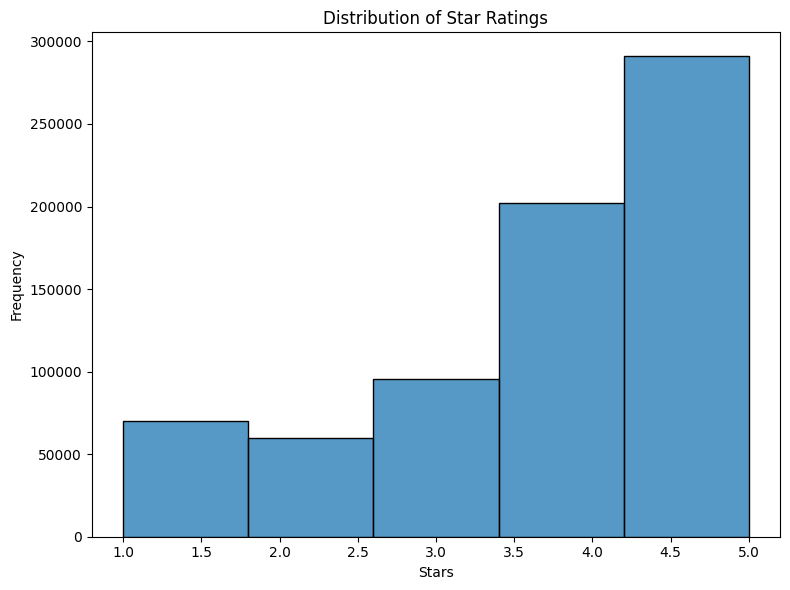

Preprocessing the dataset...
Sampling a balanced subset of the dataset...
Subset created with shape: (71838, 4)
Preparing datasets for training...


<ipython-input-25-52dc089fee28>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = review_df.groupby('sentiment_id', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))


Map:   0%|          | 0/50286 [00:00<?, ? examples/s]

Map:   0%|          | 0/10776 [00:00<?, ? examples/s]

Map:   0%|          | 0/10776 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-43-9c68f34d2164>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-26 21:34:14,905] A new study created in memory with name: no-name-6abfae03-3f66-4697-9fe3-877f48e92c49


Starting hyperparameter search...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fitsumbahlbi (fitsumbahlbi-lighthouse-labs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.500500,0.620049,0.743411,0.740742,0.738950,0.743411
2,0.737100,0.673850,0.748979,0.749490,0.752252,0.748979
3,0.527500,0.742160,0.751021,0.749832,0.749833,0.751021


[I 2025-03-26 22:09:59,639] Trial 0 finished with value: 3.0017062886564543 and parameters: {'learning_rate': 5.753479812542046e-06, 'num_train_epochs': 3, 'seed': 10, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 3.0017062886564543.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁██
eval/loss,▁▄█
eval/precision,▁█▇
eval/recall,▁▆█
eval/runtime,▃▁█
eval/samples_per_second,▆█▁
eval/steps_per_second,▆█▁
train/epoch,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
train/grad_norm,▃▂▂▂▂▂▃▅▃▃▂▄▂▂▄▂▁▃▅▁▁▁▄▁▃▁▅▆▇▁▅▄▁▄▄▆▂▂▁█


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.595900,0.650240,0.726707,0.714854,0.720082,0.726707
2,0.441300,0.641894,0.732554,0.731042,0.730203,0.732554


[I 2025-03-26 22:33:23,815] Trial 1 finished with value: 2.9263527308431763 and parameters: {'learning_rate': 1.7708084870413041e-06, 'num_train_epochs': 2, 'seed': 40, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 3.0017062886564543.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▂▃▄▁▁▄▇▅▁▄▆▄▄▂▃▃▄▅▃▂▂▂▁▄▄▃▄▅█▄▃▃▂▄▅▂▃▃▃


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.623300,0.655784,0.704993,0.697325,0.696432,0.704993
2,0.640700,0.636812,0.712973,0.707949,0.705429,0.712973


[I 2025-03-26 22:52:27,650] Trial 2 finished with value: 2.8393244100302857 and parameters: {'learning_rate': 1.1433436865877384e-06, 'num_train_epochs': 2, 'seed': 5, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.0017062886564543.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇████
train/grad_norm,▁▁▁▁▁▃▂▂▂▂▃▂▃▇▄▃▃▄▃▄▃▄▃▃▄▇▃▄█▇▄▃▂▃▄▇▃▅▃▄


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.600100,0.570217,0.743597,0.737262,0.743205,0.743597
2,0.452900,0.572073,0.755475,0.754180,0.754072,0.755475


[I 2025-03-26 23:10:29,932] Trial 3 finished with value: 3.019202593972865 and parameters: {'learning_rate': 7.909607297856461e-05, 'num_train_epochs': 2, 'seed': 5, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 3.019202593972865.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
train/grad_norm,█▃▃▂▂▂▄▃▅▄▂▂▂▄▃▁▁▃▂▂▃▅▄▂▅▃▂▃▃▅▃▂▆▄▄▃▅▃▄▃


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.629200,0.583861,0.734503,0.732203,0.731295,0.734503
2,0.527300,0.578029,0.740349,0.737752,0.736719,0.740349


[I 2025-03-26 23:28:34,721] Trial 4 finished with value: 2.9551686843061806 and parameters: {'learning_rate': 7.730782977368753e-06, 'num_train_epochs': 2, 'seed': 17, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 3.019202593972865.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▁▁▄▃▄▅▃▇▅▃▃▄▆▄▅▄▄▄▄▅▄▄▇▅▄▆▃▄▄▅▅▃▄▆▅▄▅▄▄█


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.573000,0.575384,0.745082,0.737900,0.736363,0.745082
2,0.475800,0.585106,0.748701,0.749958,0.751718,0.748701
3,0.332300,0.714850,0.748237,0.746101,0.748691,0.748237
4,0.213000,0.941304,0.739143,0.741803,0.745285,0.739143


[I 2025-03-27 00:04:32,944] Trial 5 finished with value: 2.965372364087041 and parameters: {'learning_rate': 8.387654000704064e-05, 'num_train_epochs': 4, 'seed': 6, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 3.019202593972865.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▅██▁
eval/f1,▁█▆▃
eval/loss,▁▁▄█
eval/precision,▁█▇▅
eval/recall,▅██▁
eval/runtime,██▃▁
eval/samples_per_second,▁▁▆█
eval/steps_per_second,▁▁▆█
train/epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇███
train/grad_norm,▃▂▃▃▁▂▃▂▂▁▂▁▂▂▂▂▃▂▃▂▁▂▁▂▂▃▃▂▂▆▃▂▃▂▃█▃▄▅▅


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.587000,0.575258,0.735802,0.736348,0.737553,0.735802


[I 2025-03-27 00:13:33,910] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/grad_norm,▁▁▄▄▂▃▂▃▃▂▆▃▄▃▃▃▆█▅▃▂▂▄▂▃▄▂▃▃▅▃▂▅▃▃▄▃▃▅▄


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.699600,0.674983,0.709818,0.699464,0.701943,0.709818


[I 2025-03-27 00:25:08,766] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇▇▇█
train/global_step,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████
train/grad_norm,▁▃▂▁▁▂▂▆▁▁▄▁▂▁▂▂▁▁▃▁▁▂▂▂▁▂▁▂▁▁▂▁▇▁█▂▁▂▂▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.830700,0.764622,0.699981,0.708396,0.728003,0.699981


[I 2025-03-27 00:36:39,135] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███
train/grad_norm,▂▁▁▂▂▁▅▃▁▁▂▂▂▁▂▁▂▃▇▁▁▃▂█▂▂▁▂▁▂▃▂▃▁▅▄▂▂▃▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.501900,0.625673,0.732739,0.732630,0.732636,0.732739
2,0.649400,0.648669,0.742390,0.742922,0.745663,0.742390
3,0.552200,0.679096,0.744061,0.739595,0.737897,0.744061


[I 2025-03-27 01:11:06,011] Trial 9 pruned. 
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-43-9c68f34d2164>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Best hyperparameters found: {'learning_rate': 7.909607297856461e-05, 'num_train_epochs': 2, 'seed': 5, 'per_device_train_batch_size': 32}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the model with the best hyperparameters...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.497100,0.565559,0.746381,0.742351,0.740630,0.746381
2,0.481600,0.583678,0.751021,0.750640,0.751576,0.751021


Evaluating the model on the test dataset...


Test results: {'eval_loss': 0.5574402809143066, 'eval_accuracy': 0.7528767631774314, 'eval_f1': 0.7475425939196183, 'eval_precision': 0.7455051771188699, 'eval_recall': 0.7528767631774314, 'eval_runtime': 42.1531, 'eval_samples_per_second': 255.64, 'eval_steps_per_second': 31.955, 'epoch': 2.0}
Saving the model...
Model saved successfully.
Removing old checkpoints to save storage...
Removed checkpoint directory: ./results


In [ ]:
import shutil
import os

def model_init():
    """
    Function to initialize the model for hyperparameter search.
    """
    return AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=3
    )

def main(perform_eda_flag=False, visualize_eda=False):
    """
    Main function to orchestrate the sentiment analysis workflow.
    """
    # --- Load and preprocess the dataset ---
    print("Loading dataset...")
    file_path = "Final.csv"  # Replace with your dataset file path
    columns = ["text", "stars"]
    review_df = load_dataset(file_path, columns)

    # Perform EDA if the flag is set
    print("Performing EDA...")
    if perform_eda_flag:
        review_df = perform_eda(review_df, visualize=visualize_eda)

    # Preprocess the data
    print("Preprocessing the dataset...")
    review_df = preprocess_yelp_reviews(review_df)
    review_df['processed_text'] = review_df['text'].apply(advanced_text_preprocessing)

    # Sample 10% of the data
    print("Sampling a balanced subset of the dataset...")
    sampled_df = sample_subset(review_df, frac=0.1)

    print("Preparing datasets for training...")
    train_dataset, val_dataset, test_dataset, tokenizer = prepare_datasets(sampled_df)

    # --- Define training arguments ---
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True
    )

    # --- Initialize the Trainer ---
    trainer = Trainer(
        model_init=model_init,  # Function to initialize the model with hyperparameters
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # --- Perform hyperparameter search ---
    print("Starting hyperparameter search...")
    best_run = trainer.hyperparameter_search(
        direction="maximize",  # Optimize for maximizing metrics
        backend="optuna",      # Use Optuna for hyperparameter optimization
        n_trials=10,           # Number of trials to run
    )
    print("Best hyperparameters found:", best_run.hyperparameters)

    # Update training arguments with the best hyperparameters
    training_args = TrainingArguments(
        output_dir=training_args.output_dir,
        per_device_train_batch_size=best_run.hyperparameters.get("per_device_train_batch_size", 8),
        learning_rate=best_run.hyperparameters.get("learning_rate", 5e-5),
        num_train_epochs=best_run.hyperparameters.get("num_train_epochs", 3),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=training_args.logging_dir,
        logging_steps=training_args.logging_steps,
        load_best_model_at_end=True
    )

    # Reinitialize the Trainer with updated arguments
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # --- Train the model ---
    print("Training the model with the best hyperparameters...")
    trainer.train()

    # --- Evaluate the model ---
    print("Evaluating the model on the test dataset...")
    test_results = trainer.evaluate(test_dataset)
    print("Test results:", test_results)

    # --- Save the model ---
    print("Saving the model...")
    trainer.save_model("/content/drive/MyDrive/LLM Project/Model")
    print("Model saved successfully.")

    # --- Remove old checkpoints to save storage ---
    print("Removing old checkpoints to save storage...")
    checkpoint_dir = "./results"
    if os.path.exists(checkpoint_dir):
        shutil.rmtree(checkpoint_dir)
        print(f"Removed checkpoint directory: {checkpoint_dir}")
    else:
        print(f"No checkpoint directory found at: {checkpoint_dir}")

# Run the main function
if __name__ == "__main__":
    main(perform_eda_flag=True, visualize_eda=True)  # Set to True if you want to perform EDA